In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
#for ntebook Jupyter
%matplotlib inline 
import matplotlib.pyplot as plt
import joypy

from ydata_profiling import ProfileReport #need to add for compatability

#print("python:", sys.executable)
#print("pandas:", pd.__version__)


C:\Users\Owner\anaconda3\envs\vsproj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
#my directory of the data- change to your directory of ddata
DATA_DIR = Path(r"C:\Users\Owner\Documents\datsci\rents")#change to where the csv files are, this is where we will read the data

#where the outputs are  gonna be
OUT_DIR  = Path(r"C:\Users\Owner\Documents\GitHub\DAT490\data") #change to where you want the data to go
OUT_DIR.mkdir(parents=True, exist_ok=True)
METRO_FILES = {
    "phoenix":     DATA_DIR / "final_zcta_dataset_phoenix.csv",
    "memphis":     DATA_DIR / "final_zcta_dataset_memphis.csv",
    "los_angeles": DATA_DIR / "final_zcta_dataset_los_angeles.csv",
    "dallas":      DATA_DIR / "final_zcta_dataset_dallas.csv",
}
#new directory for names
METRO_NAMES = {
    "phoenix": "Phoenix-Mesa-Chandler, AZ",
    "memphis": "Memphis, TN-MS-AR",
    "los_angeles": "Los Angeles-Long Beach-Anaheim, CA",
    "dallas": "Dallas-Fort Worth-Arlington, TX"
}


#keep this for spatial analysis
METRO_CONFIGS = {
    "phoenix": {
        "name": "Phoenix-Mesa-Chandler, AZ",
        "cbsa_code": "38060",
        "state_fips": "04",
        "county_fips_list": ["013", "021"],
        "zip_prefixes": ["85"],
        "utm_zone": 32612
    },
    "memphis": {
        "name": "Memphis, TN-MS-AR",
        "cbsa_code": "32820",
        "state_fips": "47",
        "county_fips_list": ["157", "047", "033"],
        "zip_prefixes": ["38", "72"],
        "utm_zone": 32616
    },
    "los_angeles": {
        "name": "Los Angeles-Long Beach-Anaheim, CA",
        "cbsa_code": "31080",
        "state_fips": "06",
        "county_fips_list": ["037"],
        "zip_prefixes": ["90", "91"],
        "utm_zone": 32611
    },
    "dallas": { #keeping dfw as it is to simplify things, just added collin fipscode
        #ping me for more cbsa codes if desired.. i was able to find them
        "name": "Dallas-Fort Worth-Arlington, TX",
        "cbsa_code": "19100",
        "state_fips": "48",
        "county_fips_list": ["113", "085", "121", "257", "439"],
        "zip_prefixes": ["75", "76"],
        "utm_zone": 32614
    }
}


In [42]:
def light_clean(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # date time formatting
    if "period" in df.columns:
        df["period"] = pd.to_datetime(df["period"], errors="coerce")

    # income_segment is encoded as "Low", "Medium" and "High"; we will make sure it is categorical
    if "income_segment" in df.columns:
        # Convert to ordered categorical
        df["income_segment"] = pd.Categorical(
            df["income_segment"],
            categories=["Low", "Medium", "High"],
            ordered=True
        )

    # enforce numeric type where it needs to be just in case
    for col in [
        "rent_to_income", "pct_rent_burden_30", "pct_rent_burden_50", "zori", "commute_min_proxy",
        "pct_commute_lt10", "pct_commute_10_19", "pct_commute_20_29", "pct_commute_30_44",
        "pct_commute_45_59", "pct_commute_60_plus", "ttw_total", "pct_drive_alone", "pct_carpool",
        "pct_car", "pct_transit", "pct_walk", "pct_wfh", "total_pop", "pct_white", "pct_black",
        "pct_asian", "pct_hispanic", "pct_other", "median_income", "stops_per_km2"
    ]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    return df

In [45]:
#this is our join. We will be keeping the above directory untouched for now
frames = []

for key, path in METRO_FILES.items():
    print(f"Loading {METRO_NAMES[key]} from {path}...")
    
    temp = pd.read_csv(path, low_memory=False)
    temp = light_clean(temp)
    
    # Tag the metro identity
    temp["metro_key"]  = key
    temp["metro_name"] = METRO_NAMES[key]
    
    frames.append(temp)

df = pd.concat(frames, ignore_index=True)

df.shape, df.head()

Loading Phoenix-Mesa-Chandler, AZ from C:\Users\Owner\Documents\datsci\rents\final_zcta_dataset_phoenix.csv...
Loading Memphis, TN-MS-AR from C:\Users\Owner\Documents\datsci\rents\final_zcta_dataset_memphis.csv...
Loading Los Angeles-Long Beach-Anaheim, CA from C:\Users\Owner\Documents\datsci\rents\final_zcta_dataset_los_angeles.csv...
Loading Dallas-Fort Worth-Arlington, TX from C:\Users\Owner\Documents\datsci\rents\final_zcta_dataset_dallas.csv...


((670, 31),
    ZCTA5CE  rent_to_income  pct_rent_burden_30  pct_rent_burden_50  \
 0    85003        0.371199           53.103617           10.291375   
 1    85004        0.365427           46.098395            8.466977   
 2    85006        0.243321           47.307833            7.905786   
 3    85007        0.261612           46.842588            7.926962   
 4    85008        0.247838           33.522505            2.522608   
 
           zori  commute_min_proxy  pct_commute_lt10  pct_commute_10_19  \
 0  1781.142157          21.953953         12.433286          41.114363   
 1  1824.106878          22.417636         14.027317          25.016263   
 2  1438.695628          24.451310          9.770753          25.927541   
 3  1450.002646          24.528932         12.625435          27.990609   
 4  1457.858483          25.473128          7.677261          35.097420   
 
    pct_commute_20_29  pct_commute_30_44  ...  pct_black  pct_asian  \
 0          27.529004          14.044

In [46]:
#ok so we can start a basic EDA
#shape(649,11)
df.describe(include='all')


,ZCTA5CE,rent_to_income,pct_rent_burden_30,pct_rent_burden_50,zori,commute_min_proxy,pct_commute_lt10,pct_commute_10_19,pct_commute_20_29,pct_commute_30_44,...,pct_black,pct_asian,pct_hispanic,pct_other,median_income,income_segment,stops_per_km2,period,metro_key,metro_name
count,670.000000,655.000000,665.000000,665.000000,583.000000,666.000000,666.000000,666.000000,666.000000,666.000000,...,670.000000,670.000000,670.000000,670.000000,6.700000e+02,670,670.000000,583,670,670
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,4,4
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Medium,NaN,NaN,los_angeles,"Los Angeles-Long Beach-Anaheim, CA"
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,332,NaN,NaN,270,270
mean,80762.252239,0.255762,46.284197,7.781516,2326.002617,30.948368,9.108996,25.155056,21.311272,24.880175,...,13.136082,9.268689,32.283109,4.821335,-5.208623e+06,NaN,3.409647,2025-09-30 00:00:00,NaN,NaN
min,38002.000000,0.105905,0.000000,0.000000,917.729377,11.008447,0.384615,5.742297,1.525886,0.000000,...,0.000000,0.000000,0.000000,0.000000,-6.666667e+08,NaN,0.000000,2025-09-30 00:00:00,NaN,NaN
25%,75253.250000,0.220620,39.453544,3.590572,1666.488095,27.398977,6.064468,20.920550,18.024307,21.192416,...,3.107975,1.887012,14.207964,2.900720,6.545853e+04,NaN,0.002793,2025-09-30 00:00:00,NaN,NaN
50%,85253.500000,0.249991,46.709805,5.486361,2108.942230,31.112406,7.959368,24.769757,20.954612,25.106000,...,6.086072,5.277773,25.428385,4.415705,8.740896e+04,NaN,1.053770,2025-09-30 00:00:00,NaN,NaN
75%,90302.750000,0.284105,53.327727,8.959445,2747.971722,34.339365,10.867190,29.085344,24.471987,28.406079,...,16.086508,11.808895,47.631979,6.015186,1.120257e+05,NaN,4.766843,2025-09-30 00:00:00,NaN,NaN
max,91803.000000,0.593256,100.000000,83.985330,12446.388889,48.623288,63.223364,59.166667,48.089202,45.173974,...,94.501678,69.246905,97.576546,77.895753,2.395182e+05,NaN,53.879431,2025-09-30 00:00:00,NaN,NaN


In [39]:
#missing data. lets deal with this later :)
df.isna().mean().sort_values(ascending=False)



zori                   0.129851
period                 0.129851
rent_to_income         0.022388
pct_rent_burden_50     0.007463
pct_rent_burden_30     0.007463
pct_commute_lt10       0.005970
commute_min_proxy      0.005970
pct_commute_60_plus    0.005970
pct_commute_20_29      0.005970
pct_commute_30_44      0.005970
pct_commute_45_59      0.005970
pct_carpool            0.005970
pct_drive_alone        0.005970
pct_car                0.005970
pct_commute_10_19      0.005970
pct_wfh                0.005970
pct_transit            0.005970
pct_walk               0.005970
ZCTA5CE                0.000000
ttw_total              0.000000
total_pop              0.000000
pct_black              0.000000
pct_white              0.000000
pct_asian              0.000000
pct_hispanic           0.000000
median_income          0.000000
pct_other              0.000000
income_segment         0.000000
stops_per_km2          0.000000
metro_key              0.000000
metro_name             0.000000
dtype: f

In [40]:
from ydata_profiling import ProfileReport
Profile = ProfileReport(df, title="Affordability + Commute Profile")
Profile.to_file("Affordability_EDA_Report.html")


Export report to file: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


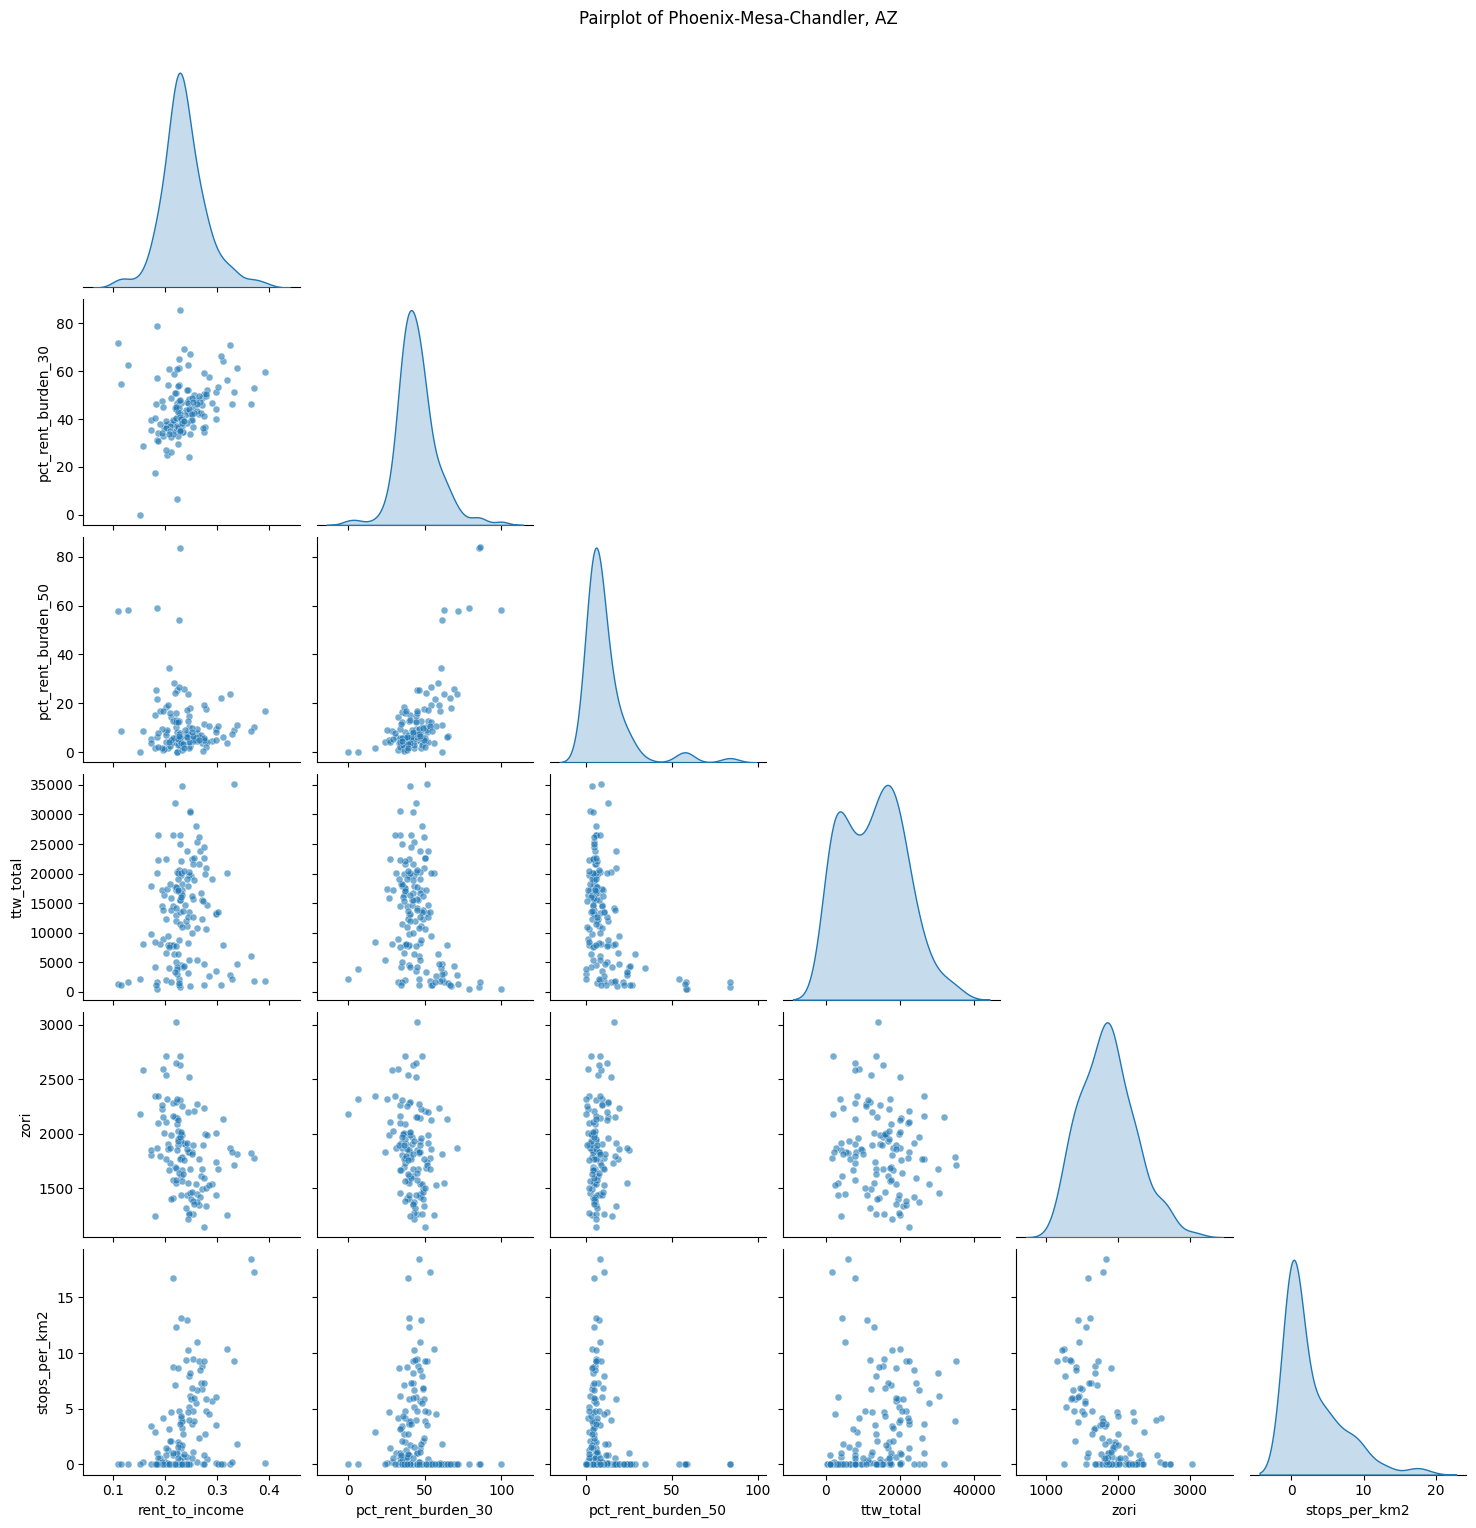

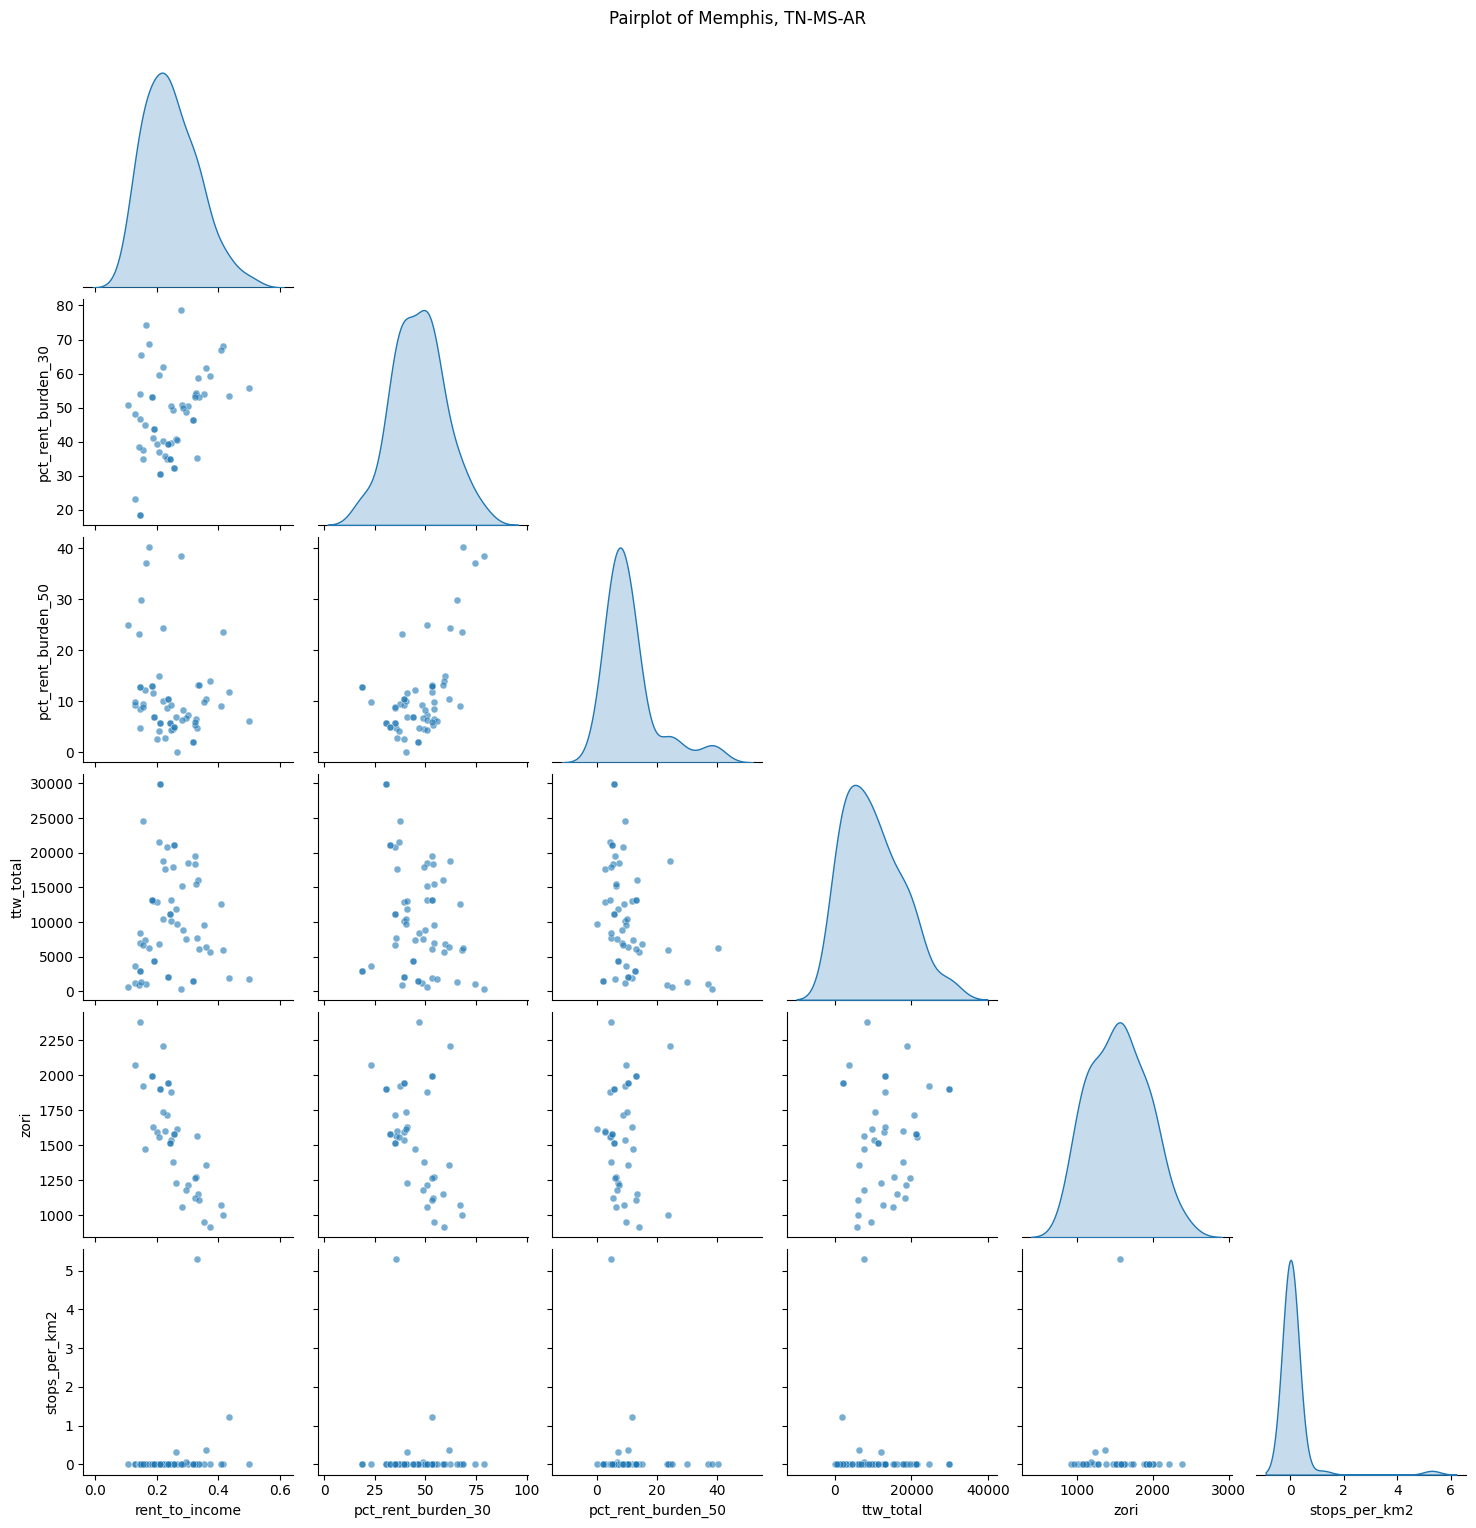

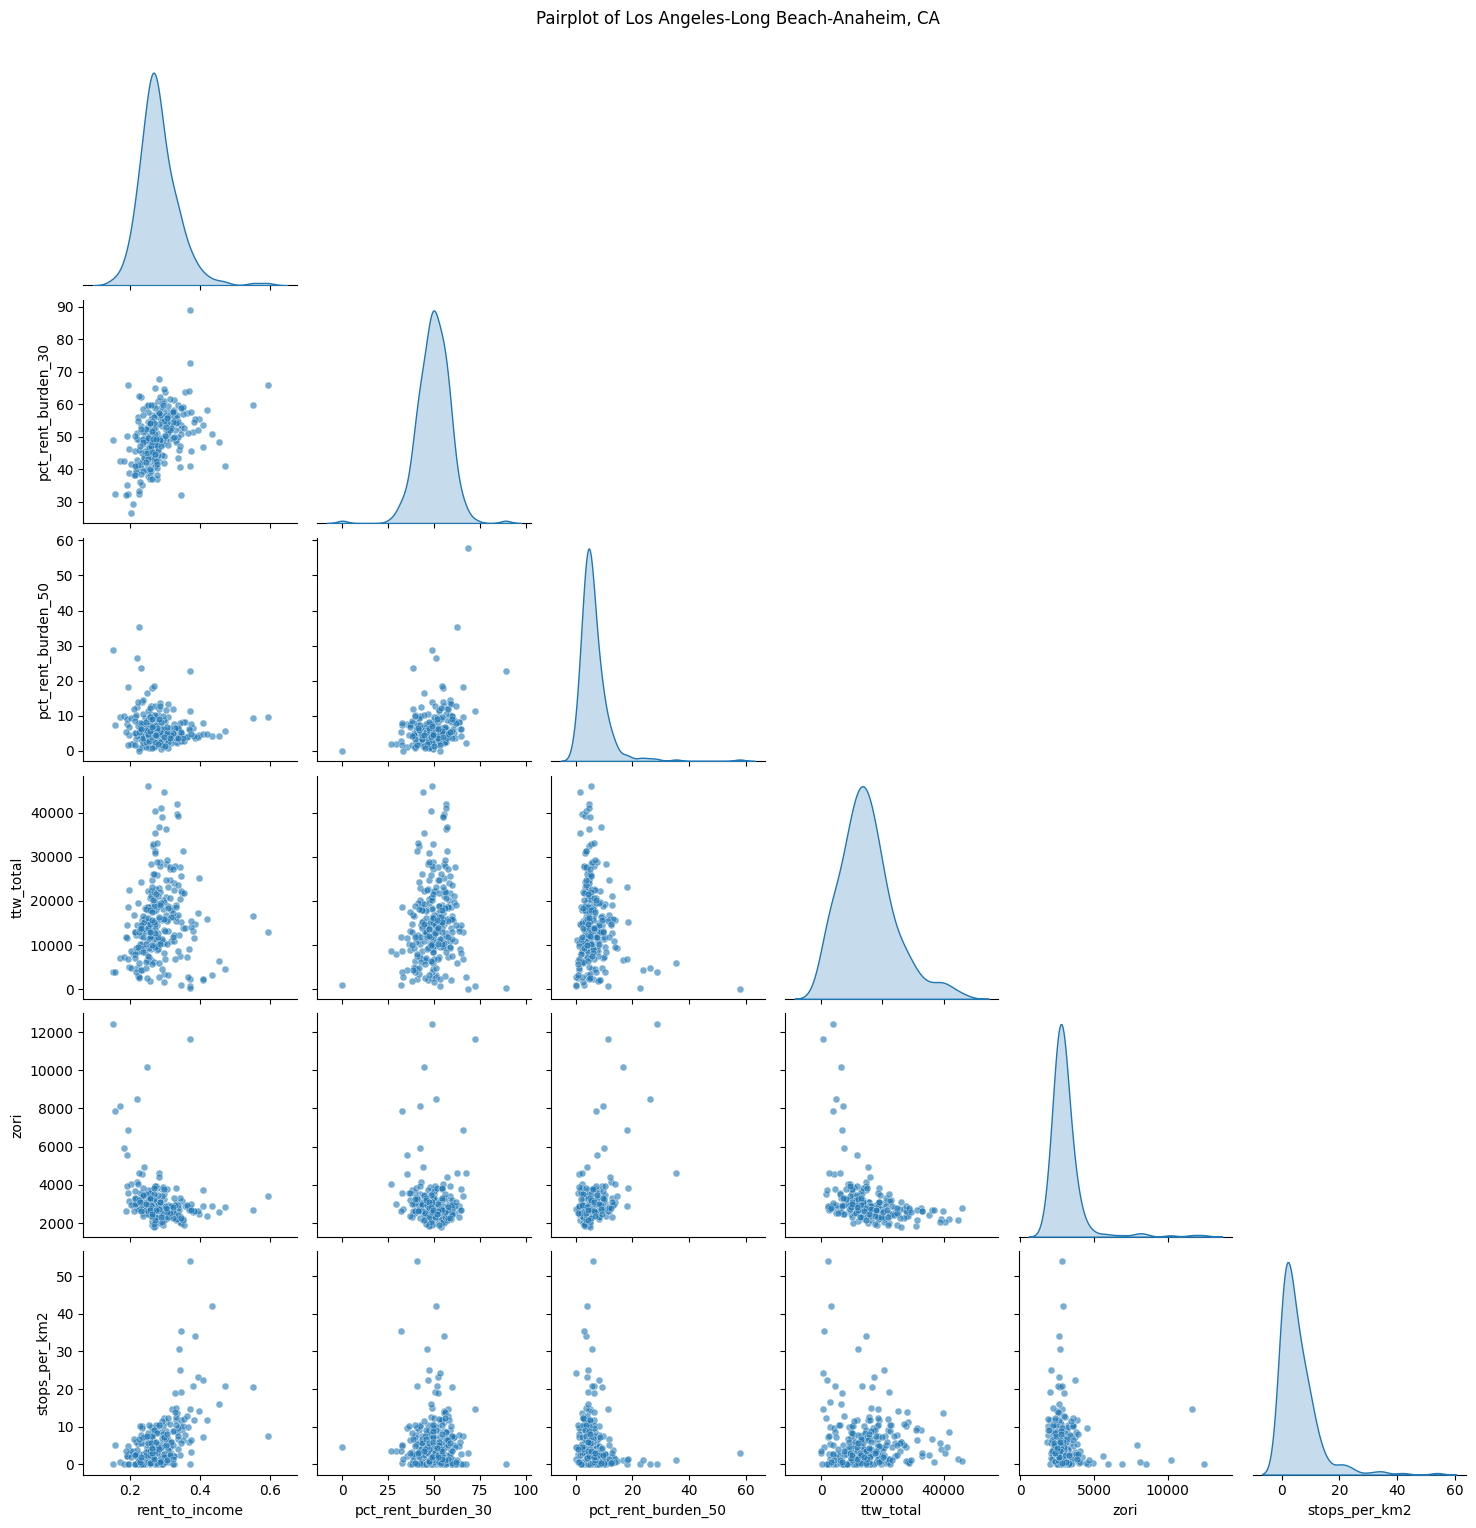

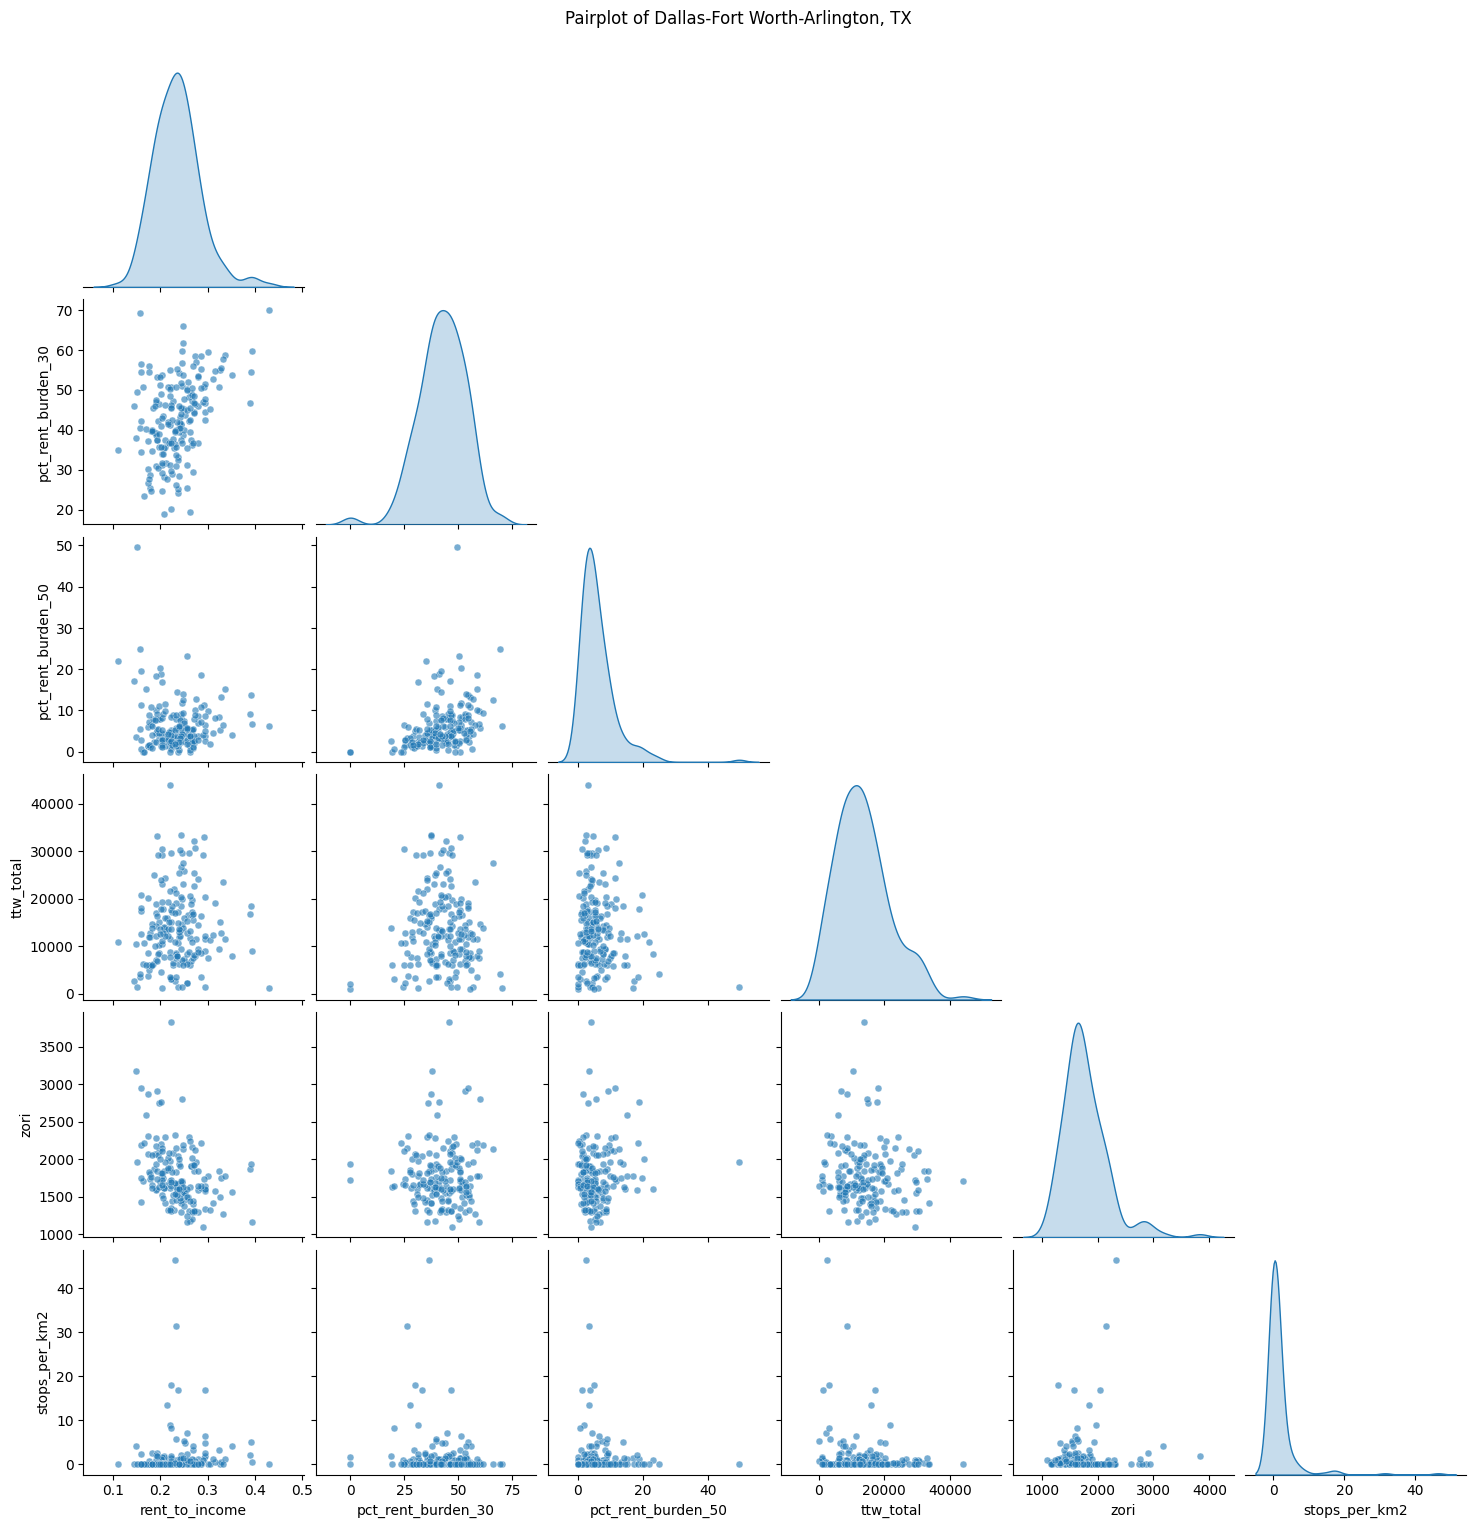

In [7]:
#I think profile is a great starting off point for the EDA. Youll have to literally stop me to not continue.
#Analysis per metro
cols = ["rent_to_income","pct_rent_burden_30", "pct_rent_burden_50","ttw_total","zori","stops_per_km2"]

for metro in df["metro_name"].unique():
    subset = df[df["metro_name"] == metro]

    g = sns.pairplot(
        subset[cols],
        diag_kind="kde",
        corner=True,
        plot_kws={"alpha":0.6, "s":25}
    )
    g.fig.suptitle(f"Pairplot of {metro}", y=1.02)
    plt.show()


In [8]:
#based on what Im seeing I think some calculations need to be standardized. They arent wrong, but they just need to account for differing metro sizes. We should also check the metro areas... I just know my area

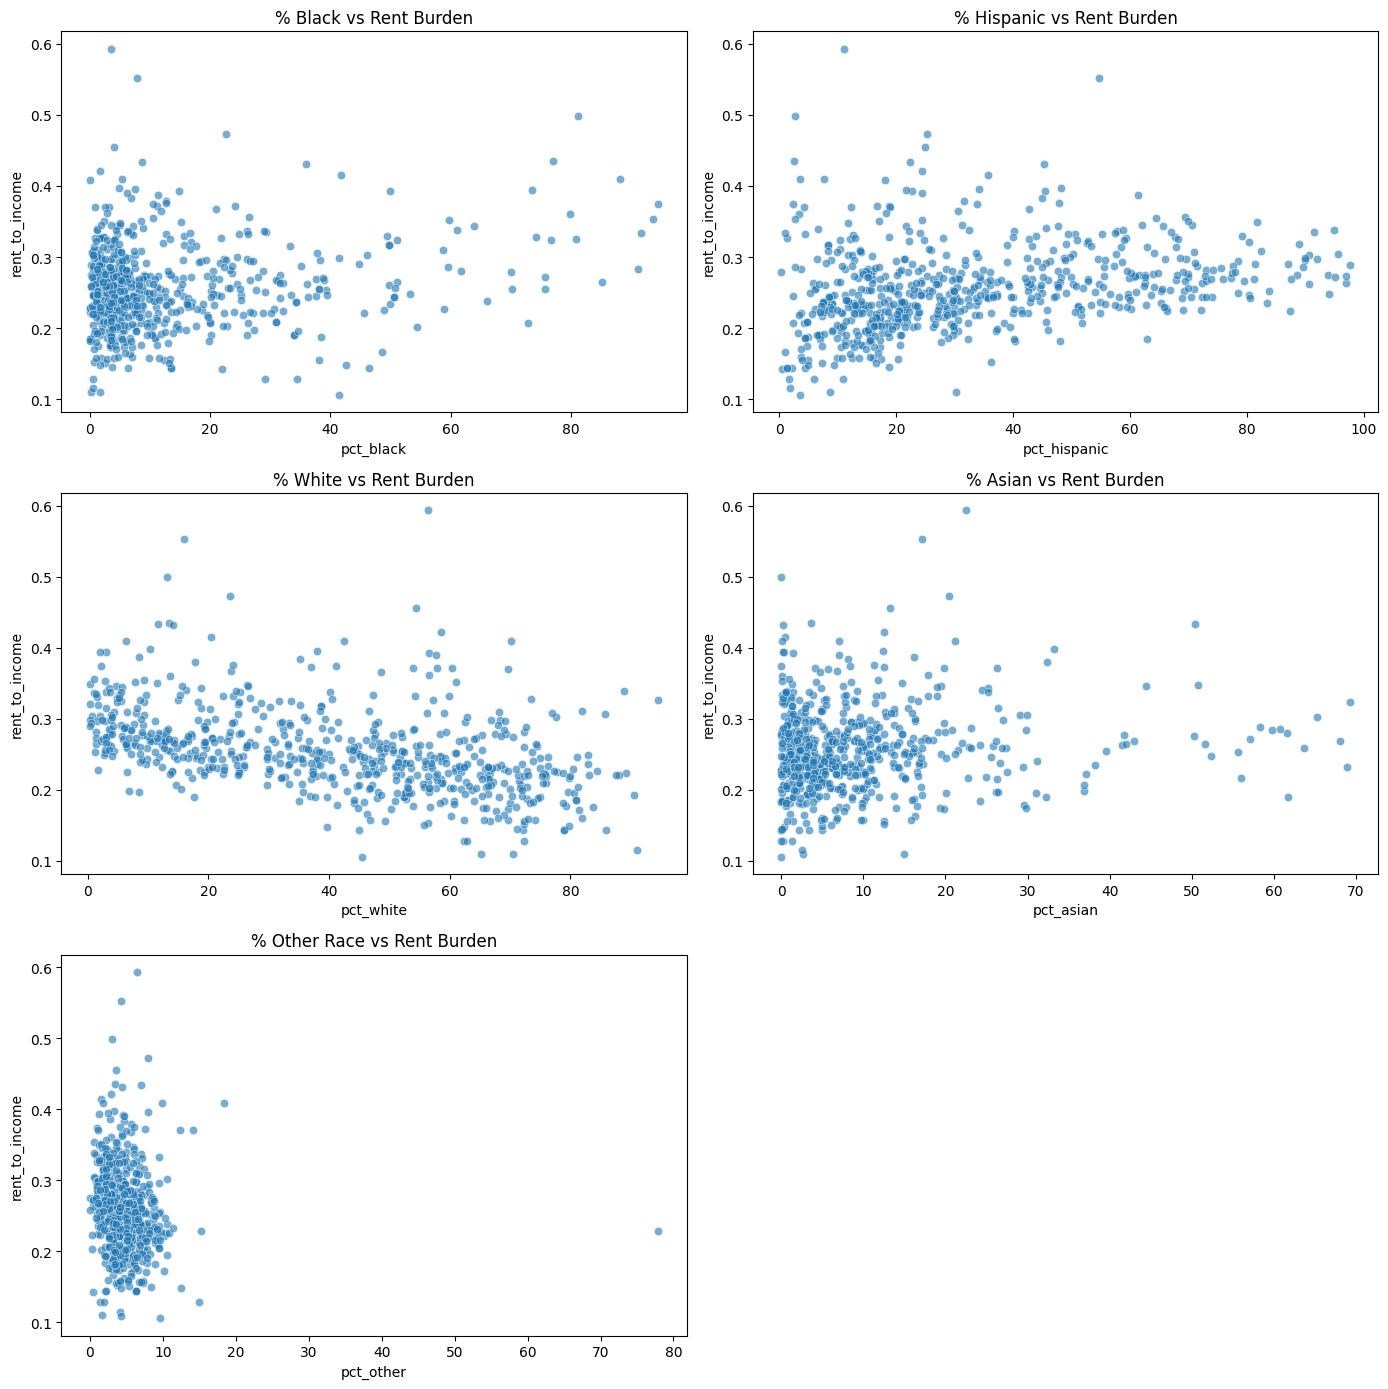

In [9]:

#Race vs Rent Burden
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

sns.scatterplot(data=df, x="pct_black", y="rent_to_income", alpha=0.6, ax=axes[0,0])
sns.scatterplot(data=df, x="pct_hispanic", y="rent_to_income", alpha=0.6, ax=axes[0,1])
sns.scatterplot(data=df, x="pct_white", y="rent_to_income", alpha=0.6, ax=axes[1,0])
sns.scatterplot(data=df, x="pct_asian", y="rent_to_income", alpha=0.6, ax=axes[1,1])
sns.scatterplot(data=df, x="pct_other", y="rent_to_income", alpha=0.6, ax=axes[2,0])

# Titles
axes[0,0].set_title("% Black vs Rent Burden")
axes[0,1].set_title("% Hispanic vs Rent Burden")
axes[1,0].set_title("% White vs Rent Burden")
axes[1,1].set_title("% Asian vs Rent Burden")
axes[2,0].set_title("% Other Race vs Rent Burden")

# Turn off the empty subplot (bottom right)
axes[2,1].axis("off")

plt.tight_layout()
plt.show()

This figure represents the rent burden by race. The rent to income ratio can generalize how much of a tenants gross income would be allocated to rental costs. One can analyze that most races observe 30% rent to income. In markets where any given race is more than 40%, there exists more variability in rent to income. The race with the highest rent burden appears to be Black Americans as there is a visual positive correlation. Hispanics are also observed to have a positive correlation of rent burden as the prospective population increases.Caucasians are observed with a lower rent burden, as there is a negative correlation as the population percentage increases.  The most variability of rent burden exists in "Other" races, as most of the population is concentrated at less than 15% of the population.

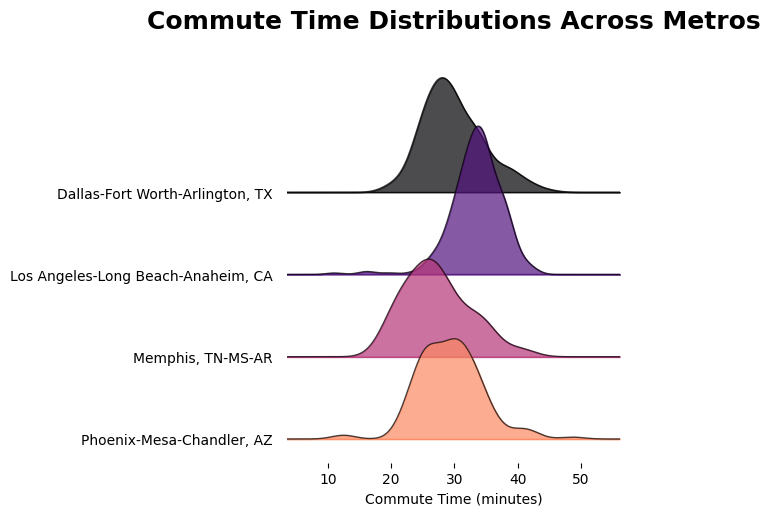

In [10]:
joypy.joyplot(
    df,
    by="metro_name",#group by metro name    
    column="commute_min_proxy",          
    kind="kde",                         
    overlap=1.4,                       
    linewidth=1,
    alpha=0.7,
    colormap=plt.cm.magma              
)



plt.title("Commute Time Distributions Across Metros", fontsize=18, weight="bold")
plt.xlabel("Commute Time (minutes)", fontsize=10)
plt.ylabel("Metro", fontsize=14)
plt.show()

This figure demonstrates the distribution of commute time segmented by easch prospective metropolitan area. One can observe prevalent commute time of between 30 and 45 minutes in the LA area. The other metropolitan areas: Dallas- Fort Worth, Memphis, and Phoenix-Mesa-Chandler experience commute times between 15 to 45 areas. There appears to be bimodal distribution times experienced within DFW and Memphis- whereas the Phoenix area experiences a trimodal distribution with notable commute times between 20 to 30 minutes, 30 and 40 minutes and over 40 minutes.